In [1]:
%load_ext autoreload
%autoreload 2

import os
import math
import time
import json
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken
from typing import Optional

from context_compression.data import DataLoaderLite
from context_compression.model import GPT, GPTConfig
from context_compression.attn import AttentionKind, ProtectionKind, SelectionHeadLinearComboKind

device_id = -1
assert torch.cuda.is_available(), "come on man. we need cuda"
device = "cuda"

enc = tiktoken.get_encoding("gpt2")


In [2]:
class DataLoaderWrapper:
    def __init__(self, B, T, process_rank, num_processes, split, use_hf_style_inputs=False):
        self.loader = DataLoaderLite(B, T, process_rank, num_processes, split, use_hf_style_inputs)
        self.loader.reset()  # ensure the internal state is initialized

    def __iter__(self):
        return self

    def __next__(self):
        # next_batch is expected to return a batch (or, if desired, you could
        # add a stopping condition to eventually raise StopIteration).
        return self.loader.next_batch()

dataloader = DataLoaderWrapper(B=2, T=64, process_rank=0, num_processes=1, split="train",use_hf_style_inputs=True)

In [3]:
from mup.coord_check import get_coord_data,plot_coord_data
from mup import set_base_shapes

def lazy_model_inner(width):
    head_dim = 64
    seq_len = 64
    assert width % head_dim == 0, "width must be divisible by 64"
    config = GPTConfig(
        n_head=width // head_dim,
        head_dim=head_dim,
        n_embd=width,
        block_size=seq_len,
        n_layer=4,
        disable_selection=True,
        epsilon=0.0, # mup doesn't work with regularization
        use_hf_style_inputs=True,
        attention_kind=AttentionKind.SELECTIVE,
        for_inference=False,
        mup=True,
        query_zero_init=True,
        readout_zero_init=True,
    )
    return GPT(config).cuda()

base_model = lazy_model_inner(64)
delta_model = lazy_model_inner(128)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:02<00:00,  2.20it/s]
/opt/conda/lib/python3.11/site-packages/mup/coord_check.py:496: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


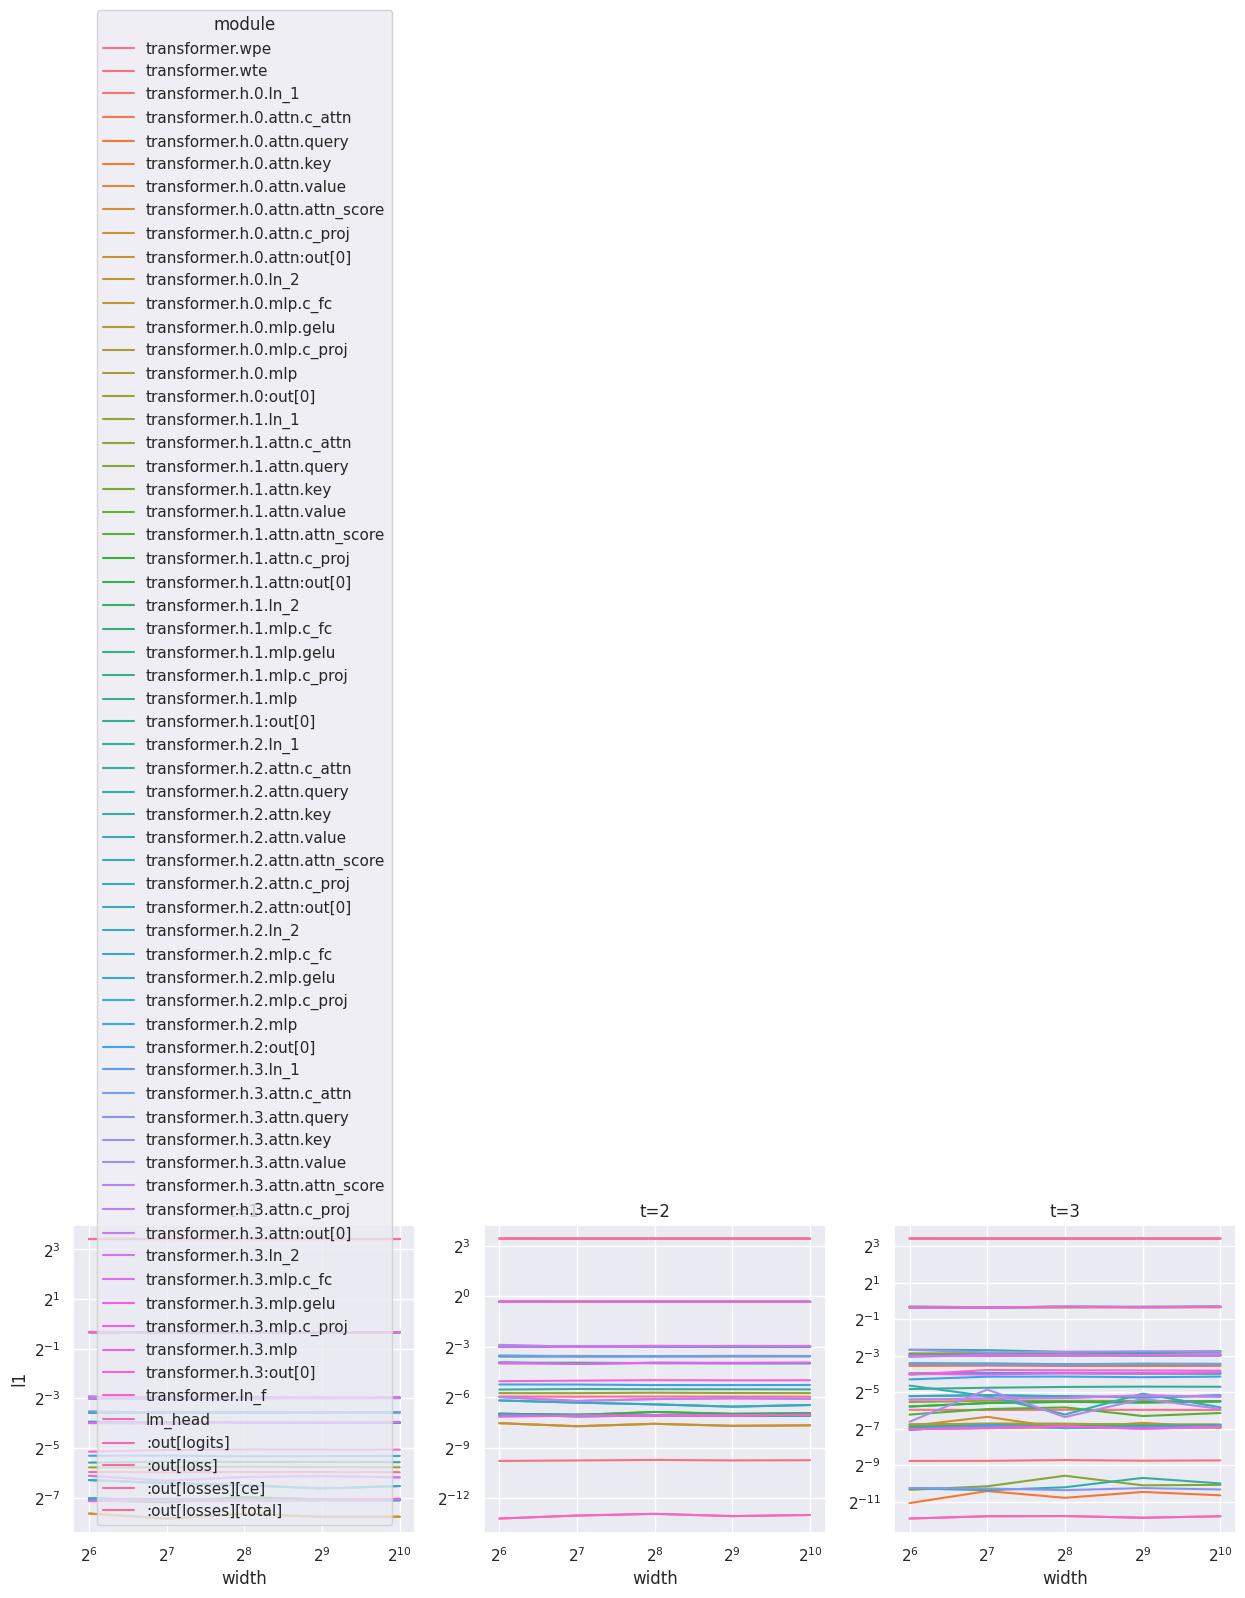

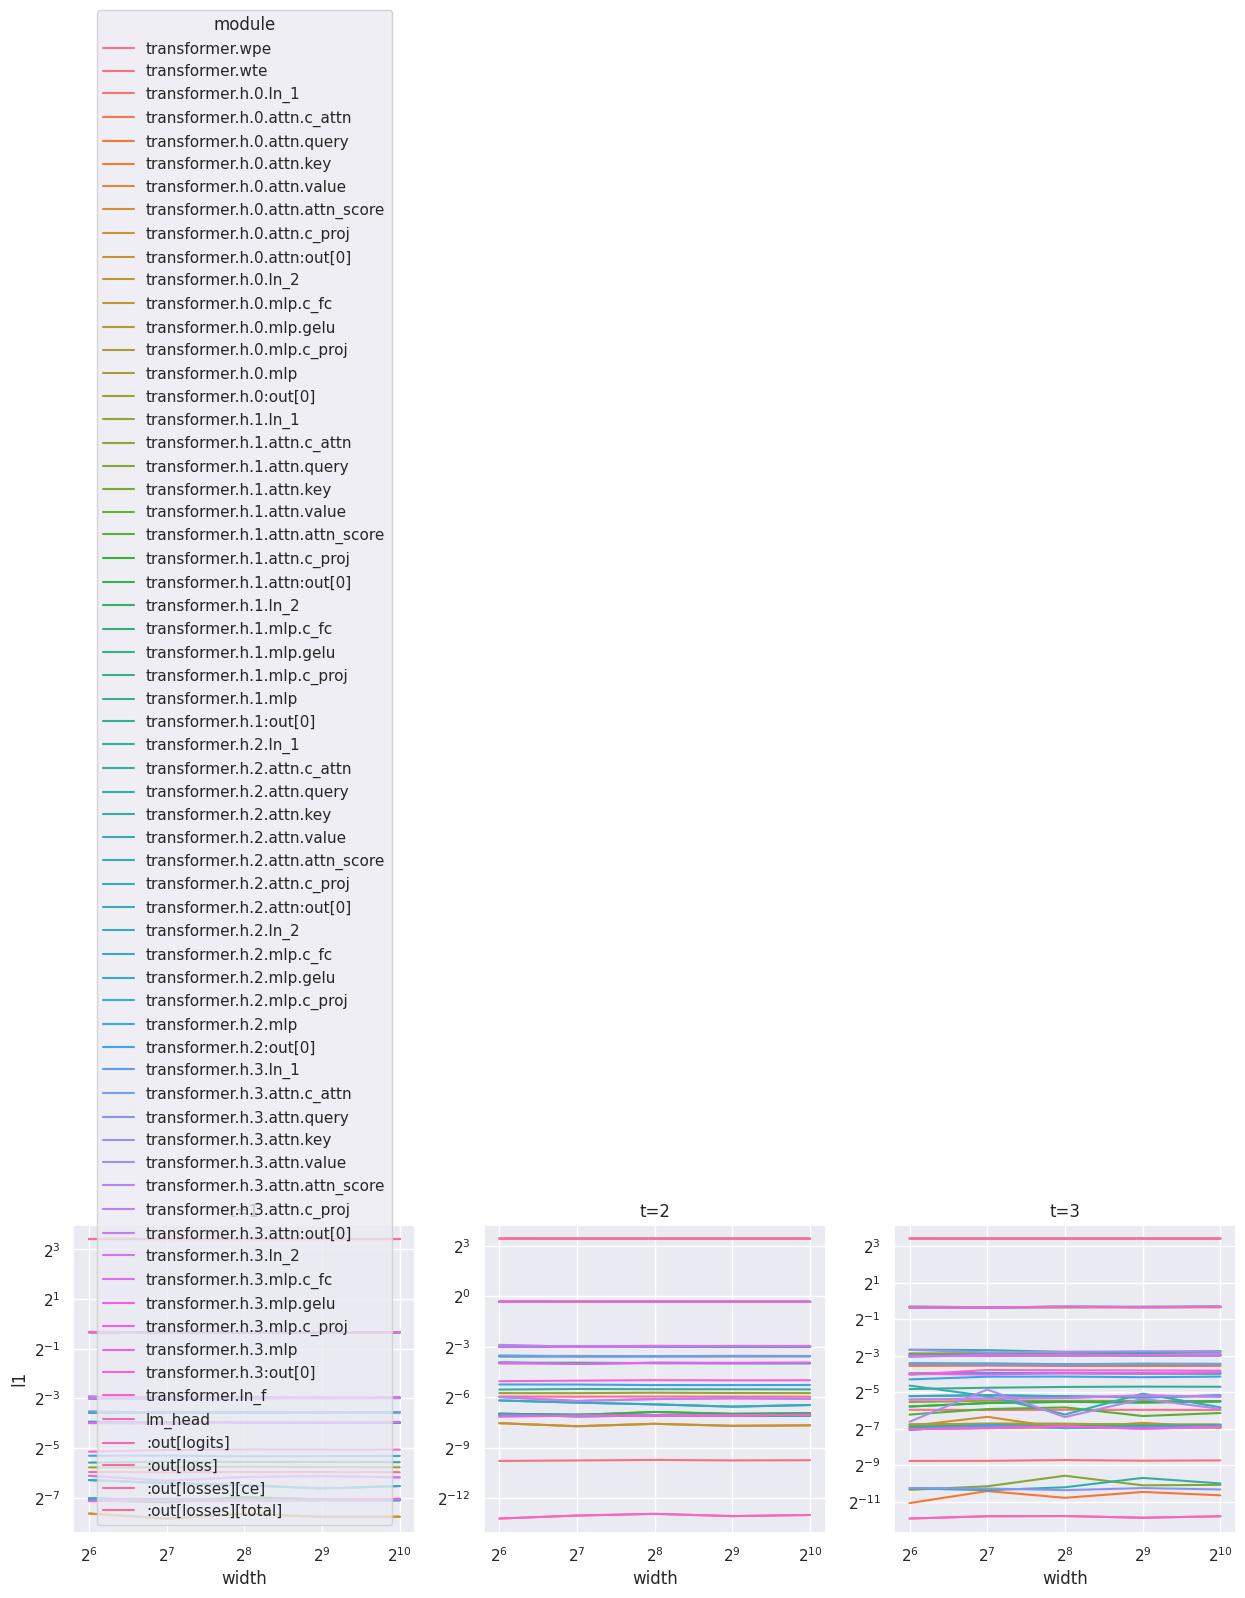

In [4]:
def lazy_model(width):
    def inner():
        model = set_base_shapes(lazy_model_inner(width),base_model,delta=delta_model,rescale_params=False)
        model.apply(model._init_weights)
        return model
    return inner

models = {64: lazy_model(64), 128: lazy_model(128), 256: lazy_model(256), 512: lazy_model(512), 1024: lazy_model(1024)}

df = get_coord_data(models,dataloader,dict_in_out=True,output_name="loss")

plot_coord_data(df)

In [30]:
# ok let's implement this ourselves!
from functools import partial


train_loader = DataLoaderWrapper(B=2, T=64, process_rank=0, num_processes=1, split="train",use_hf_style_inputs=True)

def train(train_loader,model,max_steps):

    model.cuda()
    
    optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=1e-3, device_type="cuda")

    stat_arrays = {}


    step_num = 0

    for batch in train_loader:
        if step_num > max_steps:
            break

        model.train()
        optimizer.zero_grad()

        batch = {k: v.cuda() for k, v in batch.items()}

        # let's register our hookso
        def hook(module, input, output, key):
            with torch.no_grad():
                if type(output) == tuple:
                    output = output[0]
                
                if stat_arrays.get(key) is None:
                    stat_arrays[key] = []
                stat_arrays[key].append(output.abs().mean().item())

        coord_check_handles = []
        for module_name, module in model.named_modules():
            if module_name == 'transformer.wte':
                coord_check_handles.append(module.register_forward_hook(partial(hook, key='token_embedding')))
            elif module_name.endswith('.attn'):
                coord_check_handles.append(module.register_forward_hook(partial(hook, key='attn')))
            elif module_name.endswith('.mlp'):
                coord_check_handles.append(module.register_forward_hook(partial(hook, key='mlp')))
            elif module_name == 'lm_head':
                coord_check_handles.append(module.register_forward_hook(partial(hook, key='lm_head')))
                

        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            output_dict = model(**batch)
            loss = output_dict['loss']

        loss = loss
        loss.backward()
        optimizer.step()

        for handle in coord_check_handles:
            handle.remove()
        
        step_num += 1
    
    return {k: torch.tensor(v).view(step_num, -1).mean(dim=1) for k, v in stat_arrays.items()}

from tqdm import tqdm
def get_coord_data(train_loader,models,max_steps):
    stat_arrays = {}

    for model in tqdm(models.values()):
        out_dict = train(train_loader,model(),max_steps)
        for key, value in out_dict.items():
            if stat_arrays.get(key) is None:
                stat_arrays[key] = []
            stat_arrays[key].append(value)

    return stat_arrays

# micro_out_dict = train(train_loader,models[64](),3)
# micro_out_dict

max_steps = 10
out_dict = get_coord_data(train_loader,models,max_steps)
# {k: torch.tensor(v).shape for k, v in out_dict.items()}


 20%|██        | 1/5 [00:00<00:00,  7.49it/s]

num decayed parameter tensors: 18, with 3,417,152 parameters
num non-decayed parameter tensors: 34, with 3,456 parameters
num low-lr selection head parameter tensors: 0, with 0 parameters
using fused AdamW: True
num decayed parameter tensors: 18, with 7,227,520 parameters
num non-decayed parameter tensors: 34, with 6,912 parameters
num low-lr selection head parameter tensors: 0, with 0 parameters
using fused AdamW: True


 60%|██████    | 3/5 [00:00<00:00,  2.54it/s]

num decayed parameter tensors: 18, with 16,027,904 parameters
num non-decayed parameter tensors: 34, with 13,824 parameters
num low-lr selection head parameter tensors: 0, with 0 parameters
using fused AdamW: True


 80%|████████  | 4/5 [00:01<00:00,  2.13it/s]

num decayed parameter tensors: 18, with 38,347,264 parameters
num non-decayed parameter tensors: 34, with 27,648 parameters
num low-lr selection head parameter tensors: 0, with 0 parameters
using fused AdamW: True
num decayed parameter tensors: 18, with 101,860,352 parameters
num non-decayed parameter tensors: 34, with 55,296 parameters
num low-lr selection head parameter tensors: 0, with 0 parameters
using fused AdamW: True


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


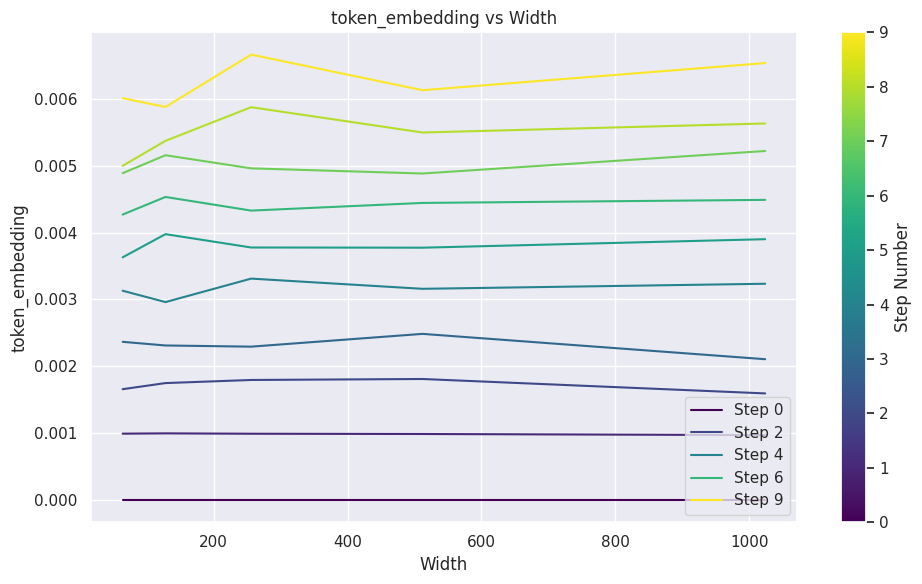

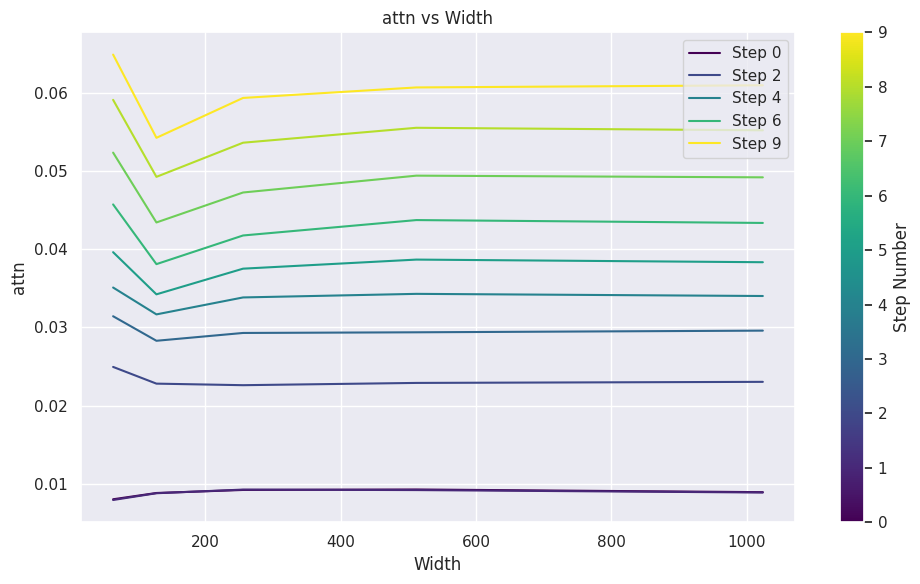

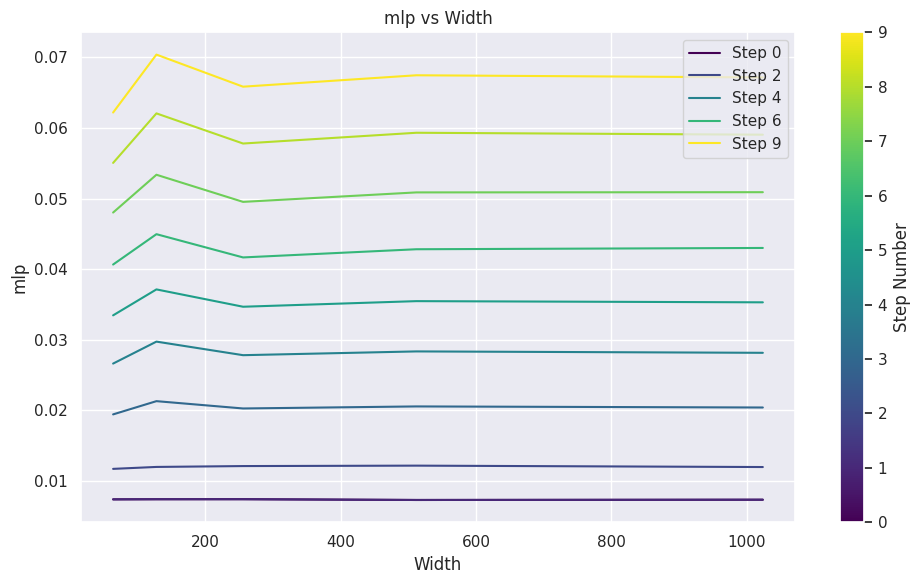

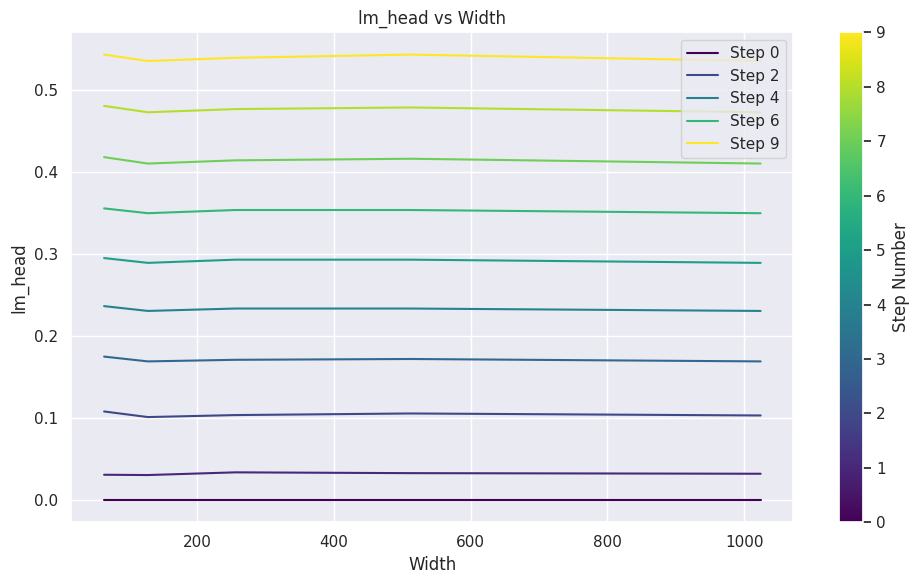

In [32]:
out_dict
{k: torch.stack(v).shape for k, v in out_dict.items()} # shape (num_widths, num_steps)

widths = list(models.keys())
step_nums = range(max_steps)

# plot one graph per key
# that graph should be:
# x axis: width
# y axis: numeric value
# one line per step, color-coded by step number (from blue=0 -> red=max_steps-1)
import matplotlib.pyplot as plt
import numpy as np

for key in out_dict.keys():
    fig, ax = plt.figure(figsize=(10, 6)), plt.gca()
    
    # Create a colormap for the steps
    cmap = plt.cm.viridis
    norm = plt.Normalize(0, max_steps-1)
    
    for step_num in step_nums:
        values = [out_dict[key][i][step_num].item() for i in range(len(widths))]
        ax.plot(widths, values, label=f'Step {step_num}', color=cmap(norm(step_num)))
    
    plt.xlabel('Width')
    plt.ylabel(key)
    plt.title(f'{key} vs Width')
    
    # Only show a few steps in the legend to avoid overcrowding
    if max_steps > 5:
        handles, labels = ax.get_legend_handles_labels()
        selected_indices = np.linspace(0, max_steps-1, 5, dtype=int)
        ax.legend([handles[i] for i in selected_indices], [labels[i] for i in selected_indices])
    else:
        ax.legend()
    
    # Create a proper colorbar with the correct mappable
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # You need to set an array for the mappable
    plt.colorbar(sm, ax=ax, label='Step Number')
    
    plt.tight_layout()
    plt.show()
